### Machine Learning with Text in sklearn:

https://github.com/justmarkham/pycon-2016-tutorial/blob/master/tutorial.ipynb

In [288]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

from matplotlib import pyplot as plt
% matplotlib inline

Basic pandas and sklearn review:

In [10]:
iris = datasets.load_iris()

In [13]:
X = iris.data
y = iris.target

In [40]:
X[1:5,]

array([[ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

In [28]:
model = LogisticRegression()

In [49]:
LogisticRegression().fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
cross_val_score(model, X, y, scoring = "log_loss")

array([-0.33141844, -0.35605088, -0.34864795])

### Representing text as numerical: Bag of Words


In [89]:
simple_train = ['call, you tonight', 'Call me a cab',
                'please call me... PLEASE!']

In [529]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [52]:
vect = CountVectorizer()

In [90]:
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [92]:
X = vect.transform(simple_train) #this is the document_term matrix.

In [91]:
X.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [93]:
vect.get_feature_names()  #these are the tokens - vectorization.

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [80]:
pd.DataFrame(X.toarray(), columns = vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [95]:
print(X) #this is how the sparse matrix is stored.

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


Predicting on new data:

In [101]:
simple_test = ["please don't call me", "hello, call me now"]

In [102]:
vect.transform(simple_test).toarray()

array([[0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 0]])

In [107]:
pd.DataFrame(vect.transform(simple_test).toarray(), 
             columns = vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0
1,0,1,1,0,0,0


### Read in text-based data: spam example

In [334]:
url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
sms = pd.read_table(url, header=None, names=['label', 'message'])

In [335]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [336]:
sms.label.value_counts()/sms.shape[0] #only 13 percent spam.

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [337]:
sms.iloc[12, 1]

'URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18'

In [338]:
from sklearn.preprocessing import LabelEncoder #creating labels.
le = LabelEncoder()
y = le.fit_transform(sms.label) 
#the issue here is we use the test data in creating the bag of words.

Let's do it with a train and test set. Two main takeways here:
- fit your bag of words on the train set only
- use stratified split

In [339]:
from sklearn.cross_validation import train_test_split

In [342]:
message = sms.message

In [343]:
message_train, message_test, y_train, y_test = train_test_split(
    X, y, random_state = 12, stratify = y) 
#use stratified here because of class imbalance

In [344]:
vect.fit(message_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [345]:
X_train = vect.transform(message_train)
X_test = vect.transform(message_test)

In [346]:
model = LogisticRegression()

In [347]:
model.fit(X_train, y_train).score(X_test, y_test)

0.97631012203876522

So we see that using train/test split correctly we get a lower score than our CV score.

Looking at the regularization parameter:

In [317]:
error = [LogisticRegression(C = i).fit(X_train, y_train).score(X_test, y_test) 
     for i in [0.001, 0.01, 0.02, 0.1, 0.5, 1, 5, 10, 50, 100]]

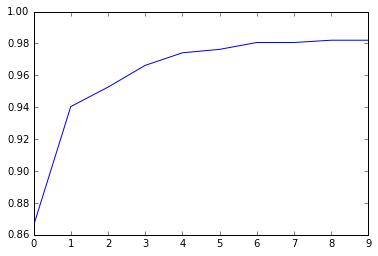

In [318]:
plt.plot(error)

In [386]:
model = LogisticRegression(penalty="l1", C = 1)
model.fit(X_train, y_train).score(X_test, y_test)

0.97702799712849964

In [393]:
1*(model.coef_ != 0).sum() #so 184 nonzero words

184

In [419]:
np.asarray(vect.get_feature_names())

array(['00', '000', '008704050406', ..., 'zoe', 'zouk', 'ú1'], 
      dtype='<U34')

In [432]:
model.coef_[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [434]:
coeffs  = pd.DataFrame({"coef":model.coef_[0],
                        "indexx":np.asarray(vect.get_feature_names())})

We can look at what coefficients the logit model found to be important:

In [677]:
coeffs[coeffs.coef != 0].sort_values(by = "coef") [1:10]

,coef,indexx
4245,-1.388691,me
6574,-1.369505,think
2925,-1.204681,fullonsms
3814,-1.016894,know
3363,-0.964258,hope
4093,-0.963090,lt
915,-0.921279,amp
3241,-0.880190,he
6228,-0.850205,still


Looking at what the classifier gets right and wrong:

In [416]:
preds = model.predict(X_test)

In [353]:
message_preds = pd.DataFrame({"message":message_test,
                              "preds":preds,
                              "true":y_test})

In [358]:
message_preds[(message_preds["preds"] == 0) &
              (message_preds["true"] == 1)]

,message,preds,true
3132,LookAtMe!: Thanks for your purchase of a video...,0,1
3272,You have 1 new voicemail. Please call 08719181...,0,1
4069,TBS/PERSOLVO. been chasing us since Sept for£3...,0,1
3750,Dear Voucher Holder 2 claim your 1st class air...,0,1
4394,RECPT 1/3. You have ordered a Ringtone. Your o...,0,1
4016,You will be receiving this week's Triple Echo ...,0,1
672,"SMS. ac sun0819 posts HELLO:""You seem cool, wa...",0,1
3885,A link to your picture has been sent. You can ...,0,1
5377,The current leading bid is 151. To pause this ...,0,1
1274,network operator. The service is free. For T &...,0,1


Looks like counting captital letter might make a difference.

In [360]:
ham_spam = message_preds[(message_preds["preds"] == 1) & #pred - spam, truth -ham
              (message_preds["true"] == 0)]

In [380]:
ham_spam.message.iloc[1]

'Miss call miss call khelate kintu opponenter miss call dhorte lage. Thats d rule. One with great phone receiving quality wins.'

The text above looks pretty spammy ha. Anyways, let's look at logloss and AUC as well:

In [440]:
model.score(X_test, y_test)

0.97702799712849964

In [444]:
from sklearn import metrics

In [445]:
preds = model.predict_proba(X_test)

In [449]:
preds = preds[:,1]

In [455]:
metrics.log_loss(y_test, preds)

0.072770761243493243

In [456]:
metrics.roc_auc_score(y_test, preds)

0.99021381506017159

In [459]:
model = LogisticRegression(solver="lbfgs").fit(X_train, y_train)

In [463]:
preds = model.predict_proba(X_test)
preds = preds[:,1]
metrics.log_loss(y_test, preds)

0.05966220872322802

In [464]:
metrics.roc_auc_score(y_test, preds)

0.99470118214630943

In [466]:
model.score(X_test, y_test)

0.97559224694903091

Interstingly the lbfgs solver is better at logloss and auc but not accuracy.

In [474]:
#trying a tree enseble for good measure
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train, y_train).score(X_test, y_test)

0.97272074659009333

### Tuning the vectorizer:

In [483]:
sms.head(3)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


#### Using stop words - eliminates comomon prepositions etc.


In [507]:
vect = CountVectorizer(stop_words="english")
vect.fit(message_train)
X_train = vect.transform(message_train)
X_test = vect.transform(message_test)

In [508]:
X_train.shape

(4179, 7183)

In [515]:
LogisticRegression().fit(X_train, y_train).score(X_test, y_test)

0.96267049533381188

#### Adding bigrams:

In [565]:
vect = CountVectorizer(ngram_range=(1,2))
vect.fit(message_train)
X_train = vect.transform(message_train)
X_test = vect.transform(message_test)

In [566]:
vect.get_feature_names()[1:10]

['00 in',
 '00 per',
 '00 sub',
 '00 subs',
 '000',
 '000 bonus',
 '000 cash',
 '000 homeowners',
 '000 pounds']

In [567]:
X_train.shape

(4179, 40935)

In [570]:
LogisticRegression(C = 1).fit(X_train, y_train).score(X_test, y_test)

0.97702799712849964

#### Limiting low frequency tokens:

In [583]:
vect = CountVectorizer(ngram_range=(1,2), min_df=3)
vect.fit(message_train)
X_train = vect.transform(message_train)
X_test = vect.transform(message_test)

In [584]:
X_train.shape

(4179, 5994)

A lof of bigrams get killed here.

NEXT: 
- use count vectorizer to do the yelp question.
- learn about tf - idf

### Tf-IDF - weigh the bag of words in a smarter way

In [628]:
simple_train = ['call, you tonight',
                'Call me a cab',
                'please call me... PLEASE!']

In [635]:
vect_1 = CountVectorizer()

In [636]:
X = vect_1.fit_transform(simple_train).toarray()

In [637]:
pd.DataFrame(X, columns = vect_1.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [661]:
tf = TfidfTransformer(use_idf = False, norm = None)

In [664]:
pd.DataFrame(tf.fit_transform(X).toarray(), columns = vect_1.get_feature_names()) 

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [669]:
tf = TfidfTransformer(use_idf = False, norm = "l2", smooth_idf = False)
pd.DataFrame(tf.fit_transform(X).toarray(), columns = vect_1.get_feature_names()) 

,cab,call,me,please,tonight,you
0,0.00000,0.577350,0.000000,0.000000,0.57735,0.57735
1,0.57735,0.577350,0.577350,0.000000,0.00000,0.00000
2,0.00000,0.408248,0.408248,0.816497,0.00000,0.00000


In [675]:
tf = TfidfTransformer(norm = None, smooth_idf = False) 
pd.DataFrame(tf.fit_transform(X).toarray(), columns = vect_1.get_feature_names()) 

,cab,call,me,please,tonight,you
0,0.000000,1,0.000000,0.000000,2.098612,2.098612
1,2.098612,1,1.405465,0.000000,0.000000,0.000000
2,0.000000,1,1.405465,4.197225,0.000000,0.000000


#### Using no normalization and no smoothing you see what's going on - you multiply each column c by 1+ ln(length(c)/#(non-zeroes in c)) - so for example me in last row has value = 1 * (1 + ln(3/2))

In [676]:
tf = TfidfTransformer(use_idf = True, norm = "l1")
pd.DataFrame(tf.fit_transform(X).toarray(), columns = vect_1.get_feature_names()) 

,cab,call,me,please,tonight,you
0,0.000000,0.227983,0.000000,0.000000,0.386009,0.386009
1,0.425325,0.251204,0.323471,0.000000,0.000000,0.000000
2,0.000000,0.176243,0.226945,0.596811,0.000000,0.000000


Now let's do tf-idf on the spam data:

In [586]:
tf = TfidfTransformer()

In [587]:
tf.fit(X_train) #you fit the already constructed bag of words here.

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [588]:
X_train = tf.transform(X_train)
X_test = tf.transform(X_test)

In [591]:
LogisticRegression(C = 10).fit(X_train, y_train).score(X_test, y_test)

0.9877961234745154

From the documentation: While the tf–idf normalization is often very useful, there might be cases where the binary occurrence markers might offer better features. This can be achieved by using the binary parameter of CountVectorizer. In particular, some estimators such as Bernoulli Naive Bayes explicitly model discrete boolean random variables. Also, very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable.